In [1]:
import pandas as pd
import seaborn as sns


df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [3]:
df.describe(include=['object'])

,sex,embarked,who,embark_town,alive
count,891,889,891,889,891
unique,2,3,3,3,2
top,male,S,man,Southampton,no
freq,577,644,537,644,549


In [6]:
df.isna().sum() / df.shape[0]

survived       0.000000
pclass         0.000000
sex            0.000000
age            0.198653
sibsp          0.000000
parch          0.000000
fare           0.000000
embarked       0.002245
class          0.000000
who            0.000000
adult_male     0.000000
deck           0.772166
embark_town    0.002245
alive          0.000000
alone          0.000000
dtype: float64

- Удалим признак alive, так как он повторяет survived
- Удалим также deck, так как в нем порядка 77% пропусков, что уже довольно неинформативно, лучше плохозаполненные такие признаки
- Дополнительно заполним пропуски модой
- Сделаем One-Hot преобразование при помощи pandas 

In [7]:
# удаление признаков 
df.drop(columns=['alive', 'deck'], inplace=True)
# заполнение пропусков модой
df.fillna(df.mode().iloc[0], inplace=True)
df_label = pd.get_dummies(df, drop_first=True)
df_label.head()

,survived,pclass,age,sibsp,parch,fare,adult_male,alone,sex_male,embarked_Q,embarked_S,class_Second,class_Third,who_man,who_woman,embark_town_Queenstown,embark_town_Southampton
0,0,3,22.0,1,0,7.2500,True,False,1,0,1,0,1,1,0,0,1
1,1,1,38.0,1,0,71.2833,False,False,0,0,0,0,0,0,1,0,0
2,1,3,26.0,0,0,7.9250,False,True,0,0,1,0,1,0,1,0,1
3,1,1,35.0,1,0,53.1000,False,False,0,0,1,0,0,0,1,0,1
4,0,3,35.0,0,0,8.0500,True,True,1,0,1,0,1,1,0,0,1


# Обучение модели

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


X = df_label.drop('survived', axis=1)
y = df_label['survived']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=42)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

clf = LogisticRegression()
clf.fit(X_train_std, y_train)

LogisticRegression()

# Интерпретация модели

Посмотрим как признаки влияют на целевую переменную

In [12]:
df_coefs = pd.DataFrame(data=clf.coef_, columns=X.columns).T
df_coefs.columns = ['Coeffecient']
df_coefs

,Coeffecient
pclass,-0.529999
age,-0.253000
sibsp,-0.575095
parch,-0.268571
fare,0.121139
adult_male,-0.685519
alone,-0.252337
sex_male,-0.109862
embarked_Q,0.029436
embarked_S,-0.072038


### ВЫВОД:

- Если пассажир был взрослым мужчиной, то это уменьшает логарифм шанса выживания на борту на 0.685
- Если пассажир садился в порту Queenstown, то это увеличивает логарифм шанса выживания на борту на 0.029

Давайте посмотрим как значение весов влияет на вероятность выжить в цифрах. Для примера возьмем первую строку из X_train датасета и умножим на значения весов и свободный коэффициент 

In [26]:
# возьмем первую строку из X_test_std
example_data = X_test_std[0].copy()
X_test.head(1)

,pclass,age,sibsp,parch,fare,adult_male,alone,sex_male,embarked_Q,embarked_S,class_Second,class_Third,who_man,who_woman,embark_town_Queenstown,embark_town_Southampton
565,3,24.0,2,0,24.15,True,False,1,0,1,0,1,1,0,0,1


In [27]:
import numpy as np
# расчитаем вероятность выжить
# умножив получившиеся коэф на соответ значения признаков
z = clf.intercept_ + sum(clf.coef_[0] * example_data)
risk = 1 / (1 + np.exp(-z[0])) # формула логистической регрессии
print(f"Вероятность выжить = {round(risk, 3)}, в процентах = {round(risk*100, 2)}%")

Вероятность выжить = 0.047, в процентах = 4.74%


Видим, что довольно низкий процент выживаемости, скорее всего, человек погибнет, так как risk < 0.5. Давайте увеличим значение признака age на единицу, так как коэффициент при этом признаке равен -0.253, то по идее с увеличением данного признака, уменьшается логарифм шанса выжить на это же число. Проверяем

In [28]:
# Попробуем увеличить значенение признака age на единицу
# уже в нормализованных данных
example_data[1] += 1

example_rev = sc.inverse_transform(pd.DataFrame(example_data).T)
print(f'Разница в возрасте: {example_rev[0][1] - X_test.iloc[0][1]}')


# снова рассчитаем вероятности
z_change = clf.intercept_ + sum(clf.coef_[0] * example_data)
risk_change = 1 / (1 + np.exp(-z_change[0]))

print(
    f"Вероятность выжить = {round(risk_change, 3)}, в процентах = {round(risk_change*100, 2)}%"
)

Разница в возрасте: 13.205868607996749
Вероятность выжить = 0.037, в процентах = 3.72%


Мы видим, что вероятно вероятность выжить уменьшилась, но не на -0.253, а на другое число, но что с логарифмом шансов?

In [29]:
print(f'Разница в логарифмах шансов: {round(z[0] - z_change[0], 3)}')

Разница в логарифмах шансов: 0.253


И тут действительно убеждаемся в нашем теоретическом материале, логарифм шанса уменьшился ровно на то же 
значение веса перед признаком age. 

<AxesSubplot:xlabel='survived', ylabel='count'>

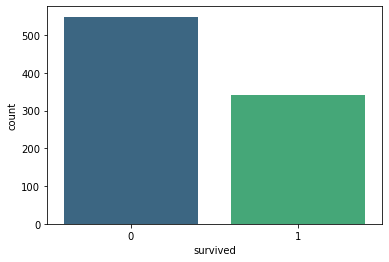

In [31]:
sns.countplot(data=df_label, x='survived', palette='viridis')

## accuracy

In [32]:
from sklearn.metrics import accuracy_score


# получаем предсказания (ответы) алгоритма
y_pred = clf.predict(X_test_std)
y_pred_train = clf.predict(X_train_std)

print(f'Accuracy Train: {accuracy_score(y_train, y_pred_train)}')
print(f'Accuracy Test: {accuracy_score(y_test, y_pred)}')

Accuracy Train: 0.8258426966292135
Accuracy Test: 0.8379888268156425


## precision & recall

In [33]:
from sklearn.metrics import precision_score, recall_score


print(f'Precision Train: {precision_score(y_train, y_pred_train)}')
print(f'Precision Test: {precision_score(y_test, y_pred)}\n')

print(f'Recall Train: {recall_score(y_train, y_pred_train)}')
print(f'Recall Test: {recall_score(y_test, y_pred)}')

Precision Train: 0.792156862745098
Precision Test: 0.8125

Recall Train: 0.73992673992674
Recall Test: 0.7536231884057971


## F1

In [34]:
from sklearn.metrics import f1_score


print(f'F1 Train: {f1_score(y_train, y_pred_train)}')
print(f'F1 Test: {f1_score(y_test, y_pred)}')

F1 Train: 0.7651515151515152
F1 Test: 0.7819548872180452


## ROC-AUC

In [35]:
from sklearn.metrics import roc_auc_score


y_pred_score = clf.predict_proba(X_test_std)
y_pred_train_score = clf.predict_proba(X_train_std)

print(f'ROC-AUC Train: {roc_auc_score(y_train, y_pred_train_score[:,1])}')
print(f'ROC-AUC Test: {roc_auc_score(y_test, y_pred_score[:,1])}')

ROC-AUC Train: 0.8690455330546447
ROC-AUC Test: 0.8683135704874835


## Попробуем на другом датасете


In [40]:
df = pd.read_csv('pima_indians_diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [67]:
X = df.drop('Outcome', axis=1)

In [68]:
y = df['Outcome']

In [69]:
X_train, X_test, y_train, y_test, = train_test_split(X, y, train_size=0.8, random_state=10, stratify=y)

In [70]:
sc = StandardScaler()
x_train_std = sc.fit_transform(X_train)
x_test_std = sc.transform(X_test)


In [71]:
model = LogisticRegression(max_iter=1000, random_state=10)
model.fit(x_train_std, y_train)

LogisticRegression(max_iter=1000, random_state=10)

In [72]:
y_pred = model.predict(x_test_std)
y_pred_train = model.predict(x_train_std)

In [73]:
print(f'Precision Test: {precision_score(y_test, y_pred).round(1)}\n')

print(f'Recall Test: {recall_score(y_test, y_pred).round(1)}\n')

print(f'f1 Test: {f1_score(y_test, y_pred).round(1)}\n')

print(f'roc_auc Test: {roc_auc_score(y_test, y_pred).round(1)}')

Precision Test: 0.8

Recall Test: 0.7

f1 Test: 0.7

roc_auc Test: 0.8
